# IMPORT

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, GRUCell
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score,average_precision_score

import random
import pandas as pd
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GCNConv,SAGEConv,GATv2Conv, GINConv, Linear

import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import copy
import itertools
import json

# LOAD DATASET

In [2]:
#'struct' for structural features 
#(pagerank, in and out degree, avg neighbor degree, avg clustering coeff)
#'text' for textual features from pre-trained multilingual SBERT
feature = 'text' 

In [3]:
snapshots = []
for i in range(4):
    snap = Data()
    snap.x = torch.load(f'steemit-hardfork-data/snapshot_{i}_x_{feature}.pt')
    snap.edge_index = torch.load(f'steemit-hardfork-data/snapshot_{i}_edge_index.pt')
    snapshots.append(snap)

/tmp/ipykernel_141085/2401050328.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snap.x = torch.load(f'steemit-hardfork-data/snapshot_{i}_x_{feature}.pt')
/tmp/ipykernel

In [4]:
snapshots

[Data(x=[77029, 384], edge_index=[2, 74306]),
 Data(x=[77029, 384], edge_index=[2, 69540]),
 Data(x=[77029, 384], edge_index=[2, 75241]),
 Data(x=[77029, 384], edge_index=[2, 82566])]

# LOAD MODEL

In [5]:
from tgnn import *

## Train

In [6]:
import random
device = torch.device('cuda')
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)
random.seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()

In [7]:
hidden_conv1 = 64
hidden_conv2 = 32

In [8]:
model, node_states = train_roland(snapshots, hidden_conv1, hidden_conv2)

Snapshot: 0
	LinkPre AVGPR Train: 0.9767229204112736, Test: 0.9767031436496756
Snapshot: 1
	LinkPre AVGPR Train: 0.8423537981722246, Test: 0.8166896107303425
Snapshot: 2
	LinkPre AVGPR Train: 0.7959857161371534, Test: 0.8725369390816458
LinkPre AVGPR over time: Train 0.8716874782402172, Test: 0.888643231153888


## Visualize

In [9]:
###CHOOSE HOP###
hop=0 #0 for 1 hop, 1 for 2 hop

### Cosine similarity

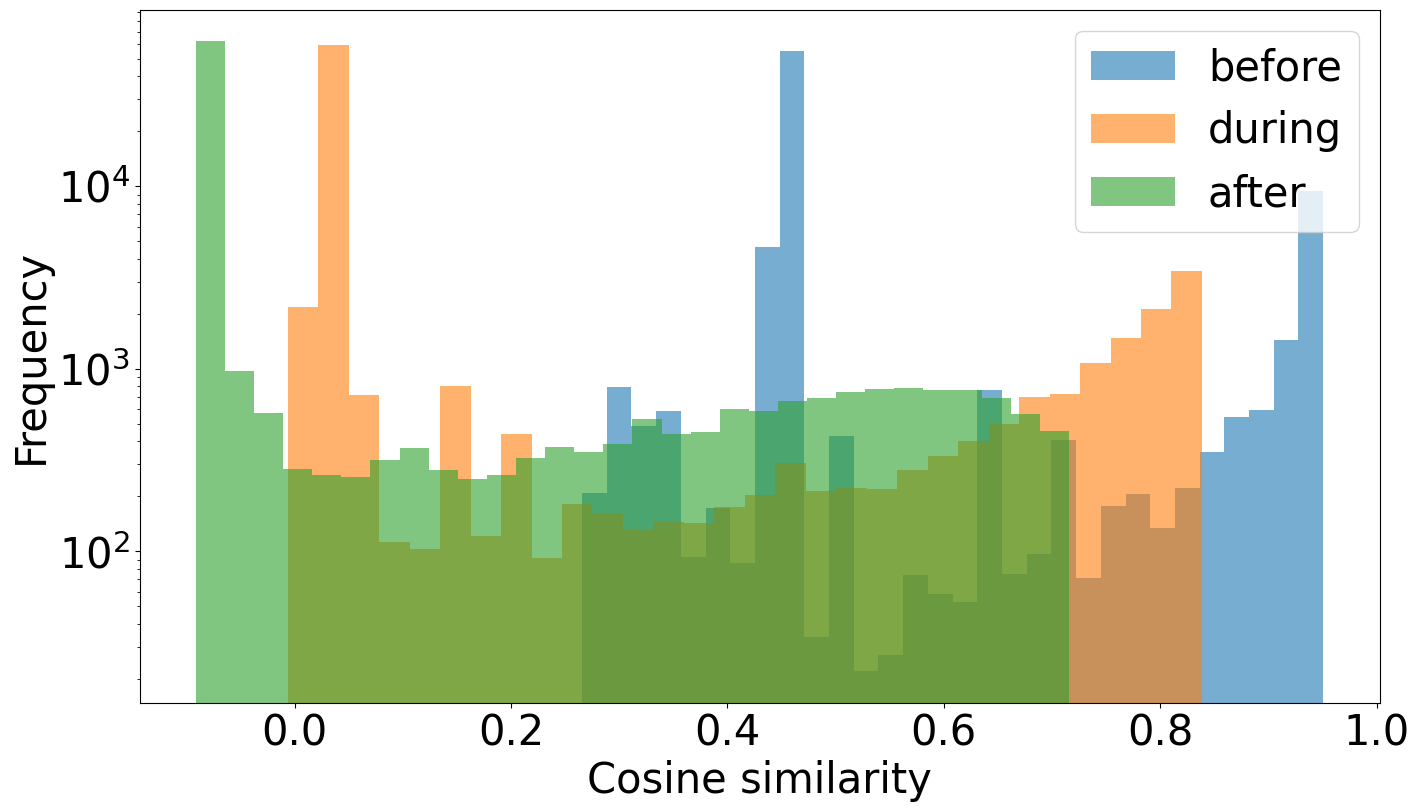

In [10]:
from torch.nn import CosineSimilarity

cosine = CosineSimilarity(dim=1, eps=1e-6)

label = {
    1: 'before',
    2: 'during',
    3: 'after'
}

plt.figure(figsize=(16,9))
for i in range(1,4):
    ti = node_states[i][hop]
    sim = cosine(node_states[0][hop], ti)
    plt.hist(sim.detach().numpy(), label=f'{label[i]}', bins=30, alpha=0.6)
    plt.legend(loc='upper right', fontsize=30)
    plt.yscale('log')
    plt.xlabel('Cosine similarity', fontsize=30)
    plt.ylabel('Frequency', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.title(f'Similarity between structural node embeddings over time ({hop+1}-hop)')
#plt.savefig(f'results/cosine_{feature}_{hop+1}.pdf', bbox_inches='tight')
#plt.savefig(f'results/cosine_text_only.pdf', bbox_inches='tight')
plt.show()

### NMI on User Clustering

In [11]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score

n_clusters = 8 #max clusters: 8 1-hop, 7 2-hop


labels = []
for i in range(0,4):
    X = node_states[i][hop].detach().numpy()
    brc = Birch(n_clusters=n_clusters) #default parameters
    brc.fit(X)
    y=brc.predict(X)
    #print(silhouette_score(X,y))
    labels.append(y)

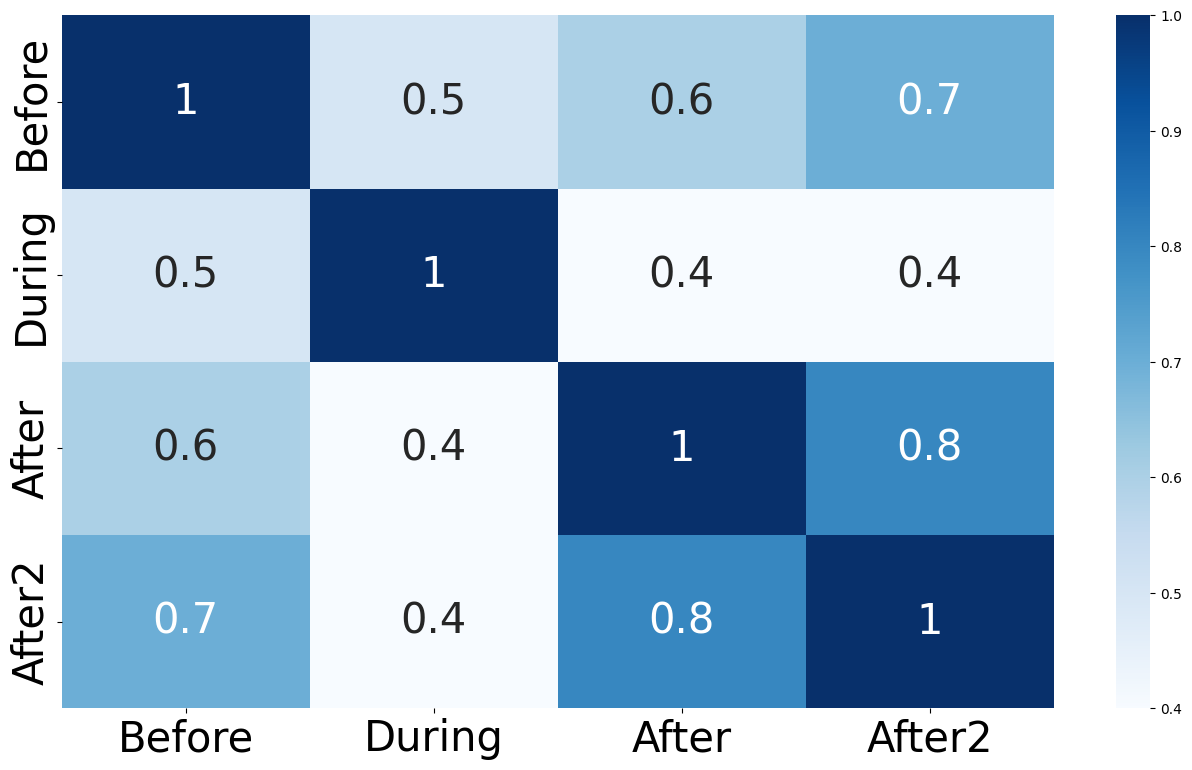

In [12]:
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score

group = ['Before','During','After','After2']

nmis = [[round(normalized_mutual_info_score(labels[j], labels[i]),1) for i in range(0,4)] for j in range(0,4)]

plt.figure(figsize=(16,9))

sns.heatmap(nmis, cmap='Blues', annot=True, xticklabels=group, yticklabels=group,\
            annot_kws={'fontsize': 30})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.title(f'NMI between structural user clustering over time ({hop+1}-hop)')
#plt.savefig(f'results/NMI_{feature}_{hop+1}.pdf', bbox_inches='tight')
plt.show()

### Polarization?

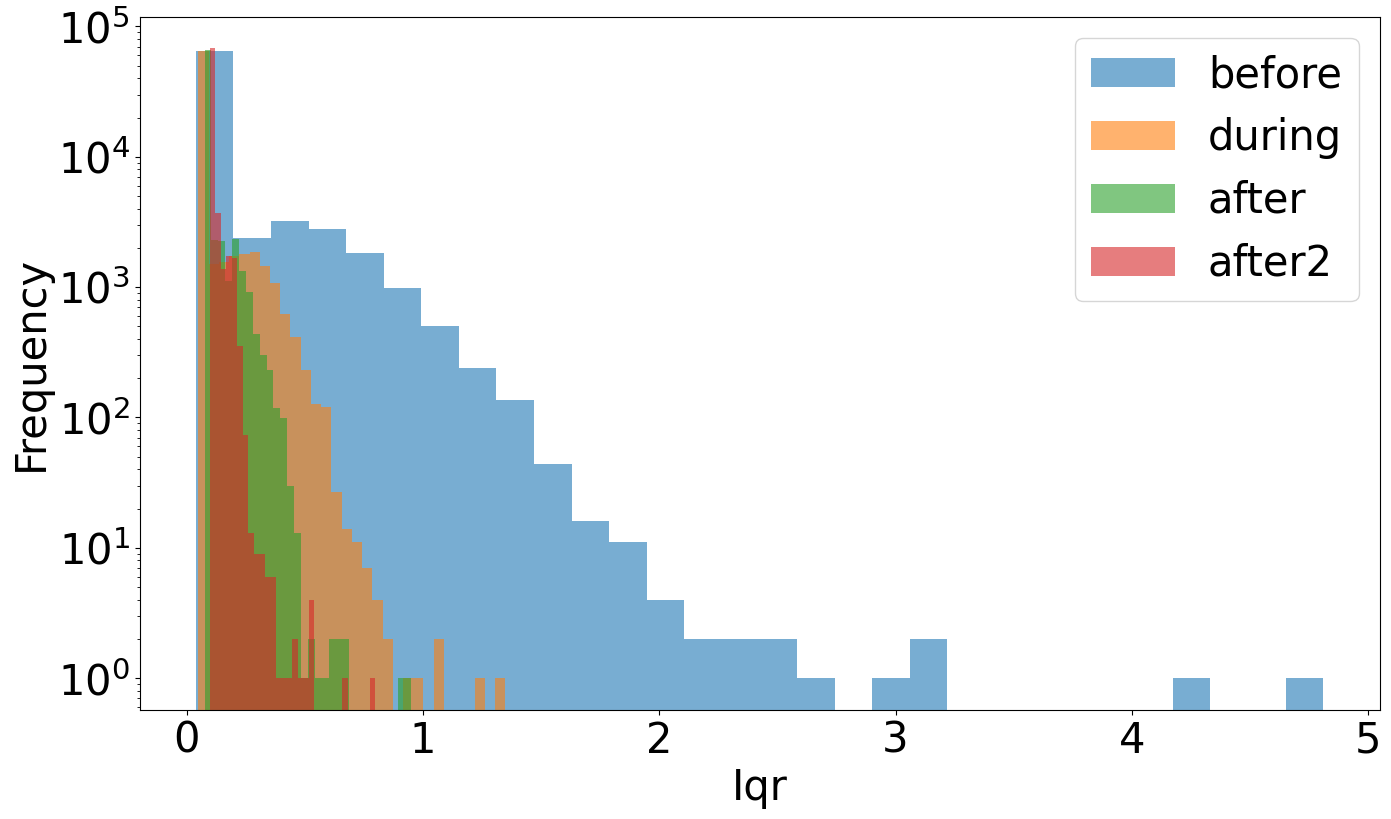

In [13]:
from scipy.stats import iqr

label = {
    0: 'before',
    1: 'during',
    2: 'after',
    3: 'after2'
    
}

plt.figure(figsize=(16,9))

for i in range(0,4):
    ti = node_states[i][hop].detach().numpy()
    g = iqr(ti,axis=1)
    plt.hist(g, label=f'{label[i]}', bins=30, alpha=0.6)
    plt.legend(loc='upper right', fontsize=30)
    plt.yscale('log')
    plt.xlabel('Iqr', fontsize=30)
    plt.ylabel('Frequency', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.title(f'Iqr of node embeddings with text ({hop+1}-hop)')
    
#plt.savefig(f'results/iqr_{feature}_{hop+1}.pdf', bbox_inches='tight')
plt.show()

### Text-only

In [14]:
###Uncomment the following lines if you want to take into account text embeddings only (without message-passing) ###
hop = 0
for i in range(len(snapshots)):
    node_states[i][0] = snapshots[i].x

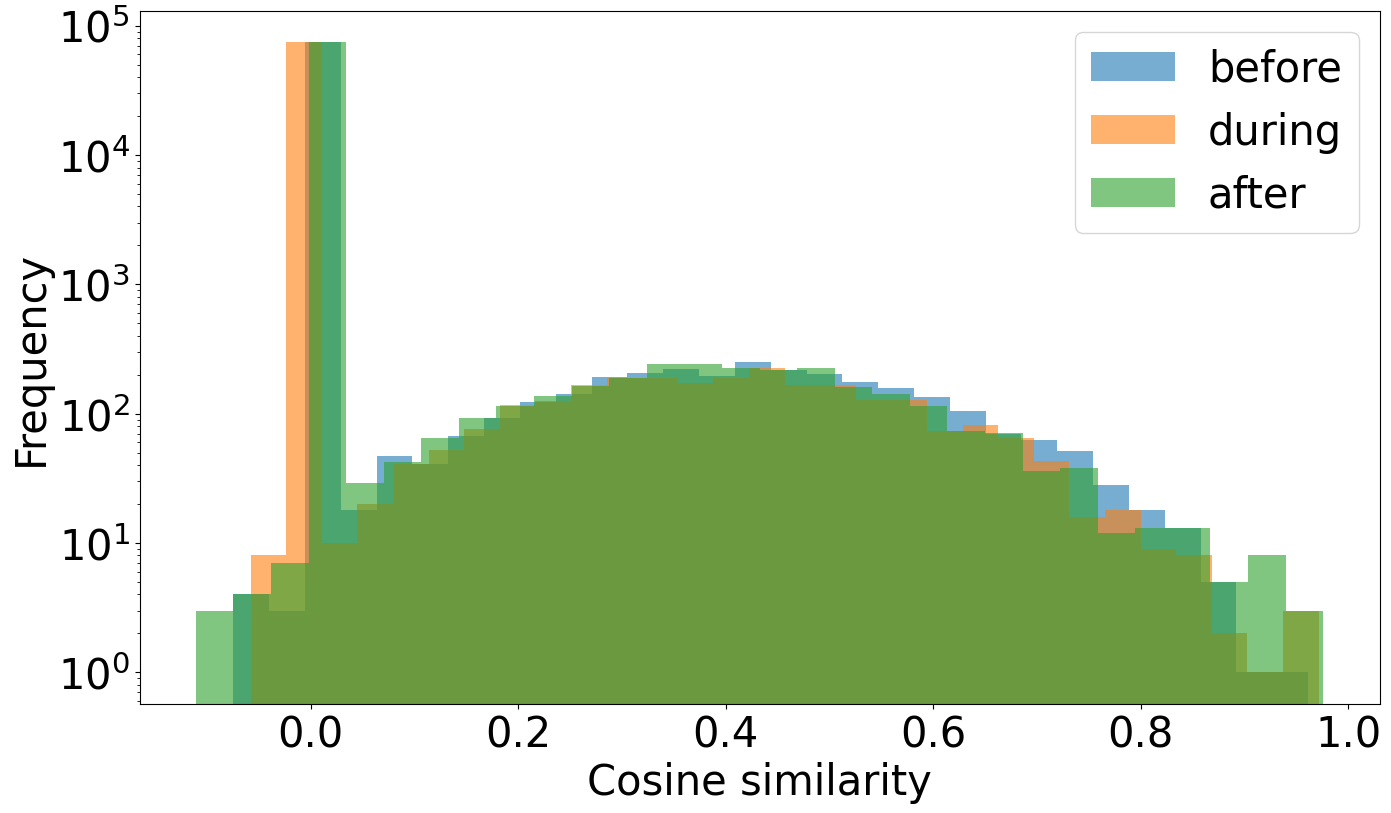

In [16]:
from torch.nn import CosineSimilarity

cosine = CosineSimilarity(dim=1, eps=1e-6)

label = {
    1: 'before',
    2: 'during',
    3: 'after'
}

plt.figure(figsize=(16,9))
for i in range(1,4):
    ti = node_states[i][hop]
    sim = cosine(node_states[0][hop], ti)
    plt.hist(sim.detach().numpy(), label=f'{label[i]}', bins=30, alpha=0.6)
    plt.legend(loc='upper right', fontsize=30)
    plt.yscale('log')
    plt.xlabel('Cosine similarity', fontsize=30)
    plt.ylabel('Frequency', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.title(f'Similarity between structural node embeddings over time ({hop+1}-hop)')
#plt.savefig(f'results/cosine_text_only.pdf', bbox_inches='tight')
plt.show()